<a href="https://colab.research.google.com/github/anologicon/jat-rail-time-series/blob/master/JatRailTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from pandas import Series
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from matplotlib.pylab import rcParams 
from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
sns.set(color_codes=True)

In [0]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/JetRail/train.csv");
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/JetRail/test.csv");

train_original = train.copy()
test_original = train.copy()

In [6]:
train.shape, test.shape

((18288, 3), (5112, 2))

In [0]:
train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(test_original.Datetime, format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime, format='%d-%m-%Y %H:%M')

In [0]:
# sometimes python scare me
for i in (train, test, test_original, train_original):
  i['year'] = i.Datetime.dt.year
  i['month'] = i.Datetime.dt.month
  i['day'] = i.Datetime.dt.day
  i['hour'] = i.Datetime.dt.hour

In [0]:
train['dayOfWeek'] = train.Datetime.dt.dayofweek
temp = train.Datetime

In [0]:
temp2 = train.Datetime.apply(lambda x:1 if(x.dayofweek == 5 or x.dayofweek == 6) else 0)
train['weekend'] = temp2

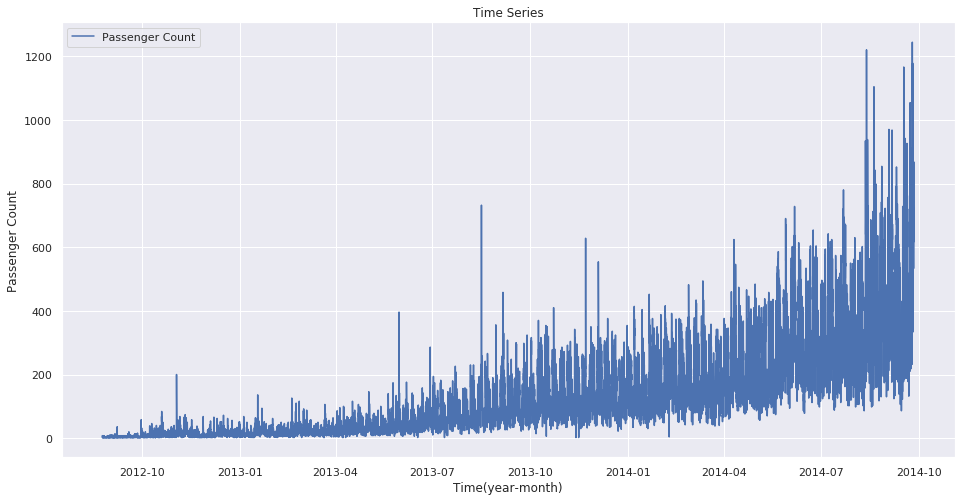

In [11]:
train.set_index('Datetime', inplace=True)

df = train.drop('ID', 1)

ts = df.Count

plt.figure(figsize=(16,8))
plt.plot(ts, label='Passenger Count')
plt.title('Time Series')
plt.xlabel('Time(year-month)')
plt.ylabel('Passenger Count')
plt.legend(loc='best')

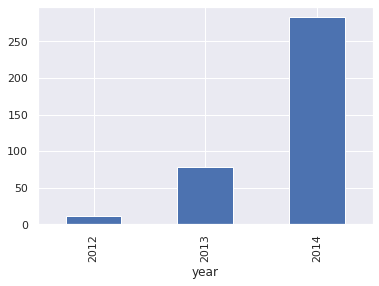

In [12]:
# Hypothesis - Traffic will increase as the yars pass by

train.groupby('year')['Count'].mean().plot.bar()

# That's a true hypothesis

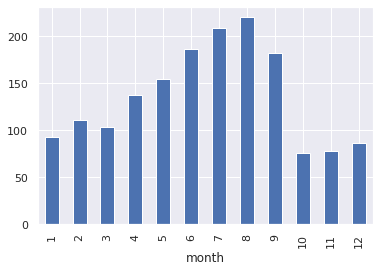

In [13]:
# Hypothesis - Increase in traffic from May to October

train.groupby('month')['Count'].mean().plot.bar()

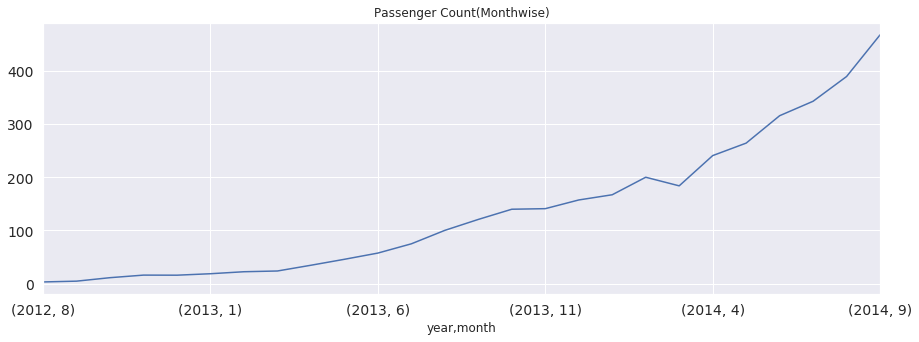

In [14]:
temp = train.groupby(['year', 'month'])['Count'].mean()

temp.plot(figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=14)

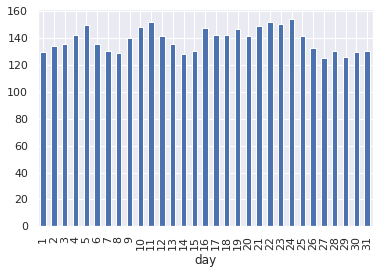

In [15]:
train.groupby('day')['Count'].mean().plot.bar()

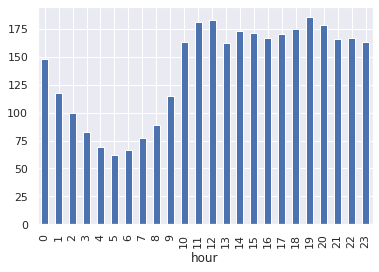

In [16]:
# Hypothesis 3 - peak hours

train.groupby('hour')['Count'].mean().plot.bar()

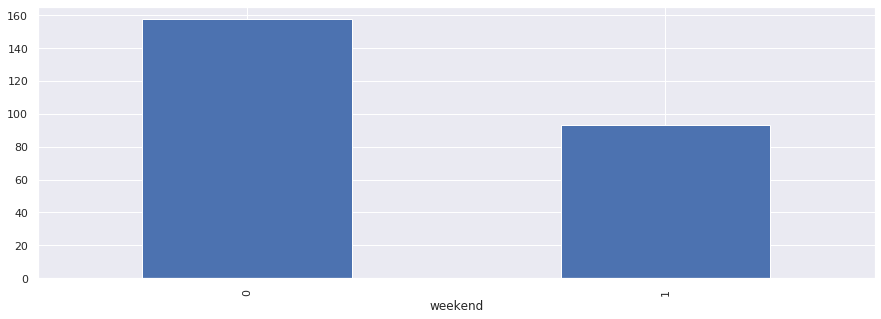

In [17]:
# Hypothesis 4 - Weekend
train.groupby('weekend')['Count'].mean().plot.bar(figsize=(15,5))

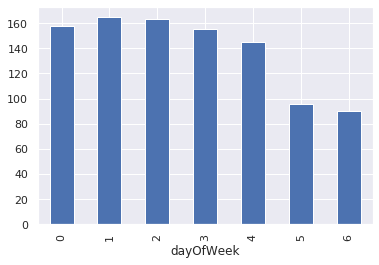

In [18]:
# Note - 0 is the starting of the week, ie. 0 is Monday and 6 Sunday.

train.groupby('dayOfWeek')['Count'].mean().plot.bar()

In [0]:
train = train.drop('ID', 1)

In [0]:
train.Timestamp = pd.to_datetime(train.index, format='%d-%m-%y %H:%M')

train.index = train.Timestamp

# Hourly time series
hourly = train.resample('H').mean()

# Converting to daily mean
daily = train.resample('D').mean()

# Converting to weekly mean
weekly = train.resample('W').mean()

# Converting to monthly mean
monthly = train.resample('M').mean()

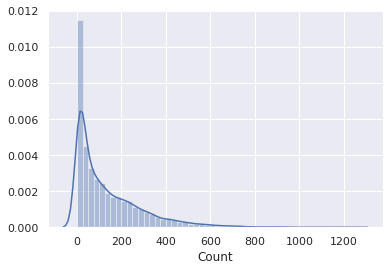

In [21]:
sns.distplot(train.Count)

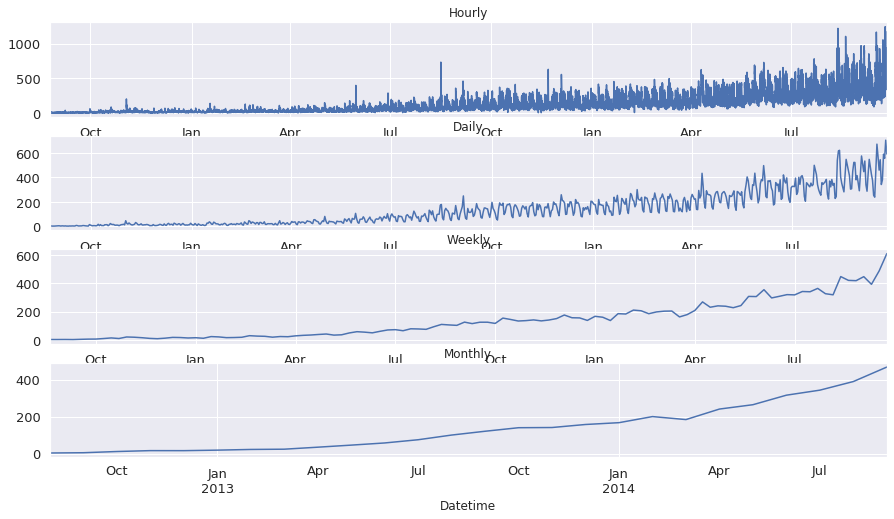

In [22]:
fig, axs = plt.subplots(4,1)

figsize = (15,8)

fontsize = 13;

hourly.Count.plot(figsize=figsize, title= 'Hourly', fontsize=fontsize, ax=axs[0])
daily.Count.plot(figsize=figsize, title= 'Daily', fontsize=fontsize, ax=axs[1])
weekly.Count.plot(figsize=figsize, title= 'Weekly', fontsize=fontsize, ax=axs[2])
monthly.Count.plot(figsize=figsize, title= 'Monthly', fontsize=fontsize, ax=axs[3])

plt.show()

In [0]:
test.Timestamp = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
test.index = test.Timestamp

# Converting to daily mean
test = test.resample('D').mean()

In [0]:
train.Timestamp = pd.to_datetime(train.index, format='%d-%m-%Y %H:%M')
train.index = train.Timestamp

# Converting to daily mean
train = train.resample('D').mean()

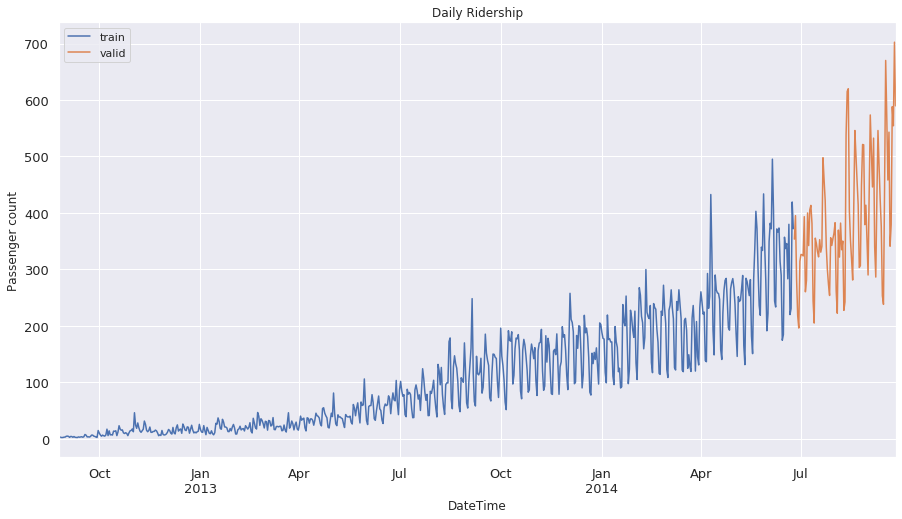

In [25]:
# Split data

Train = train.ix['2012-08-25':'2014-06-24']
valid = train.ix['2014-06-25':'2014-09-25']

Train.Count.plot(figsize=figsize, title= 'Daily Ridership', fontsize=fontsize, label='train')
valid.Count.plot(figsize=figsize, title= 'Daily Ridership', fontsize=fontsize, label='valid')

plt.xlabel("DateTime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

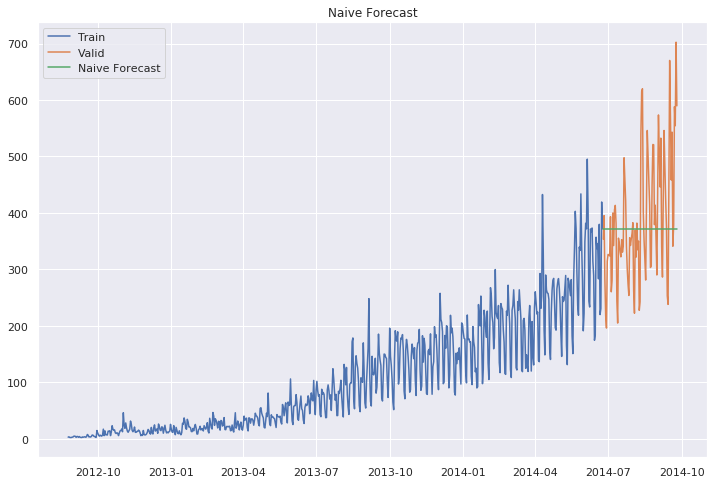

In [26]:
# Naive Approach

dd = np.asarray(Train.Count)
y_hat = valid.copy()
y_hat['naive'] = dd[len(dd)-1]

plt.figure(figsize=(12,8))
plt.plot(Train.index, Train['Count'], label='Train')
plt.plot(valid.index, valid['Count'], label='Valid')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [27]:
# RMSE (Root Mean Square Error)
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive))
print(rms)

111.79050467496724


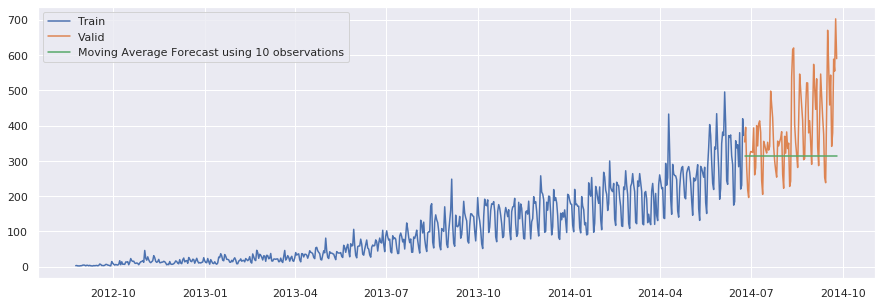

In [28]:
# Moving Average

# average of last 10 obsevations
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1]

plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations') 
plt.legend(loc='best') 
plt.show()

In [29]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)) 
print(rms)

134.23733308950264


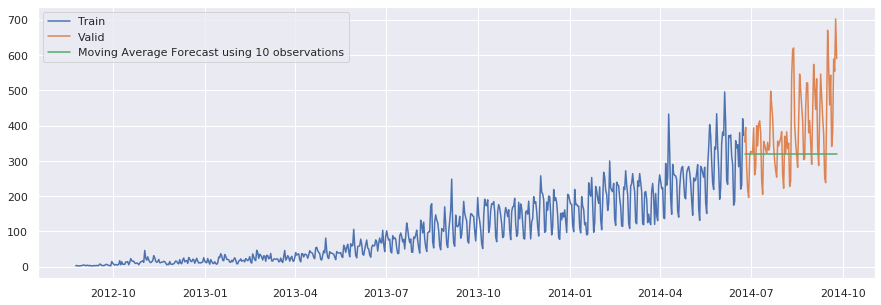

In [30]:
# avarage of last 20 observations

y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1]

plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations') 
plt.legend(loc='best') 
plt.show()

In [31]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)) 
print(rms)

130.44984977550422


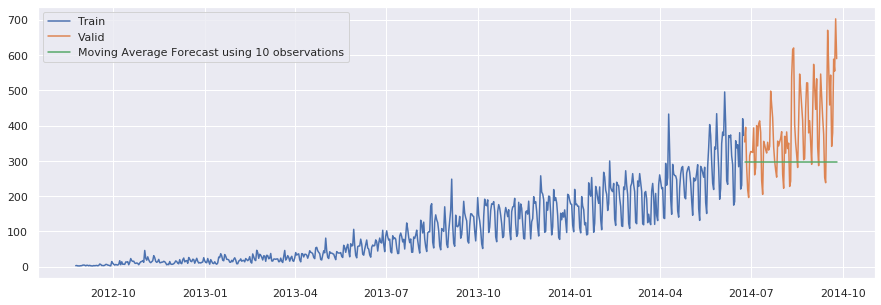

In [32]:
# avarage of last 50 observations

y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1]

plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations') 
plt.legend(loc='best') 
plt.show()

In [33]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)) 
print(rms)

144.19175679986802


In [0]:
# Exponential Smoothing

y_hat_avg = valid.copy()

fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(
    smoothing_level=0.6,
    optimized=False
)

y_hat_avg['SES'] = fit2.forecast(len(valid))

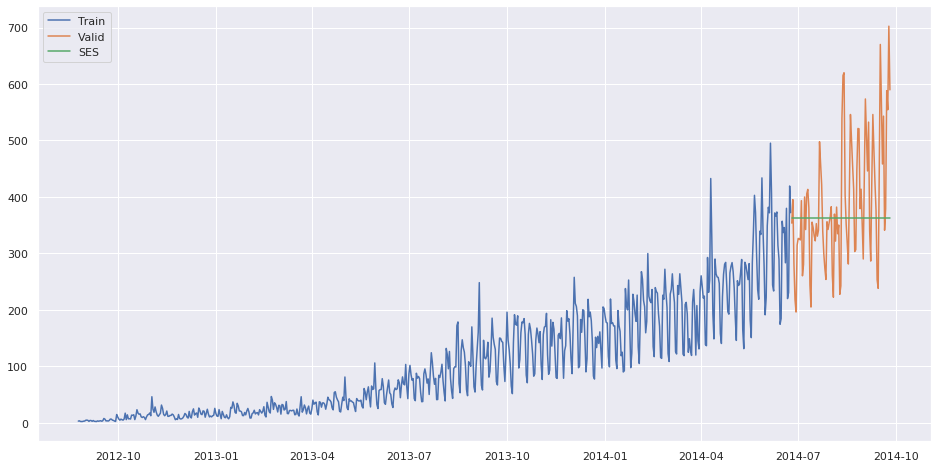

In [35]:
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [36]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SES))
print(rms)

113.43708111884514


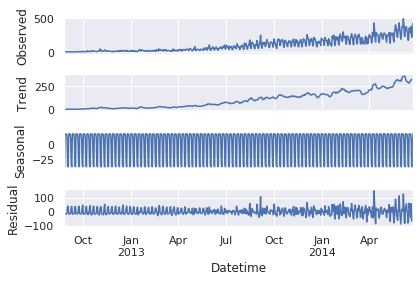

In [37]:
# Note: Explain, wtf mean this graph's.

sm.tsa.seasonal_decompose(Train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)

plt.show()

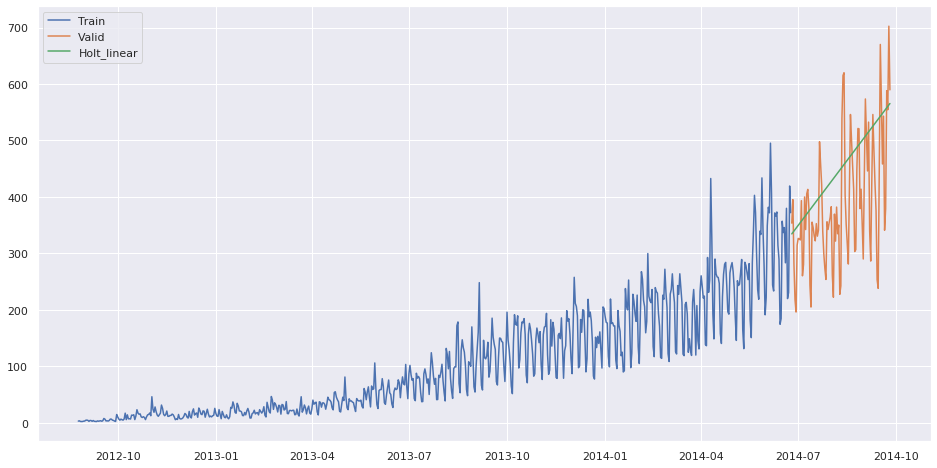

In [38]:
 y_hat_avg = valid.copy()
 fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
 y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))

 plt.figure(figsize=(16,8))
 plt.plot(Train['Count'], label='Train')
 plt.plot(valid['Count'], label='Valid')
 plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
 plt.legend(loc='best')
 plt.show()

In [39]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linear))
print(rms)

112.94278345314041


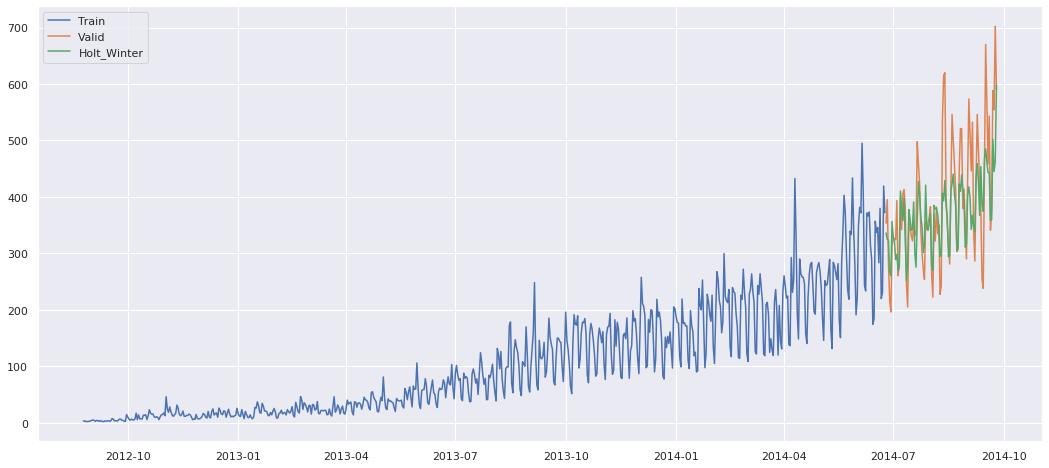

In [40]:
y_hat_avg = valid.copy()

# Note: Estudy more about the parameters.
fit1 = ExponentialSmoothing(np.asarray(Train['Count']), seasonal_periods=168, trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid))

plt.figure(figsize=(18,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [41]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter))

print(rms)

74.22041262736023


In [0]:
# ARIMA MODEL (Auto Regression Integrated Moving Average) :D

# P - The order of the autoregressive model (Numbers of time lags)
# D - The degree of differencing (number of time the data have had past values subtracted)
# Q - The order of moving average model.

# Note - How you can explain that for a HUMAN????

# Stationary Time Series - How to know if the series is stationary:

# Note - How you can know about that's factors? And ith term ?

# The mean of time series should be a constant, in function of time.
# The variance of the time series should not be a function of time.
# The covariance of the ith term and the (i+m)th term should not be a function of time.

# Note - https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

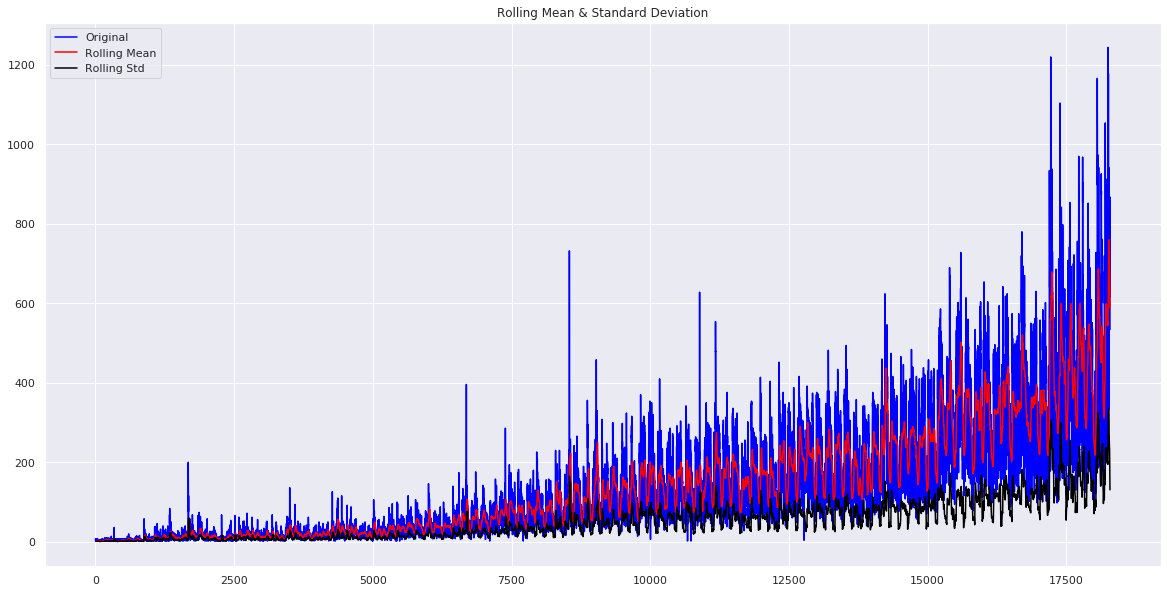

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
dtype: float64
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
dtype: float64
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [43]:
# Make sure the time series is stationary. If not, we will make it stationary

# Dickey-Fuller test.

def test_stationarity(timeseries):
  #Determing rolling statistics
  rolmean = timeseries.rolling(window=24).mean()  
  rolstd = timeseries.rolling(window = 24).std()
  #Plot rolling statistics:
  orig = plt.plot(timeseries, color='blue',label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)
  #Perform Dickey-Fuller test:
  print ('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

rcParams['figure.figsize'] = 20,10
test_stationarity(train_original['Count'])

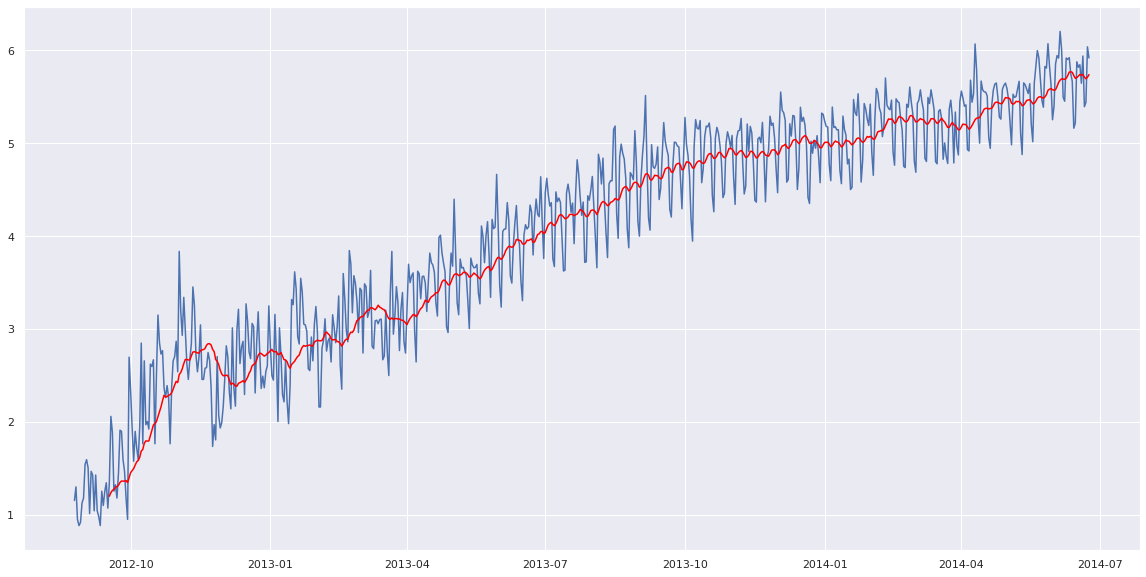

In [44]:
# Removing Trend

Train_log = np.log(Train['Count'])
valid_log = np.log(valid['Count'])

moving_avg = Train_log.rolling(window=24).mean()  
plt.plot(Train_log)
plt.plot(moving_avg, color = 'red')
plt.show()

In [0]:
train_log_moving_avg_diff = Train_log - moving_avg

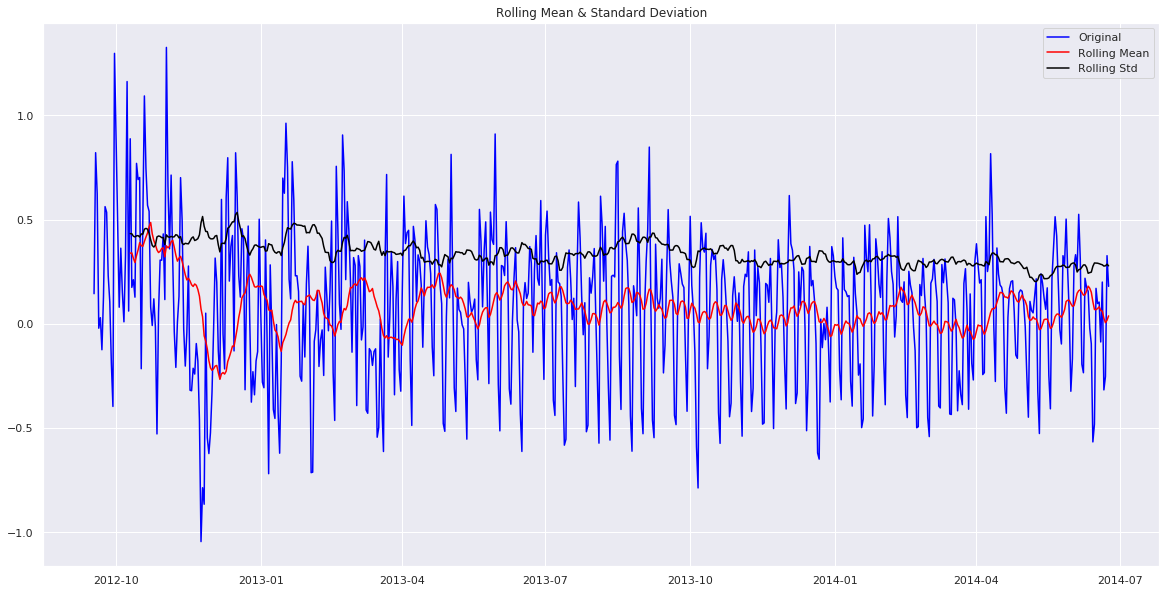

Results of Dickey-Fuller Test:
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
dtype: float64
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
dtype: float64
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [46]:
train_log_moving_avg_diff.dropna(inplace=True)

test_stationarity(train_log_moving_avg_diff)

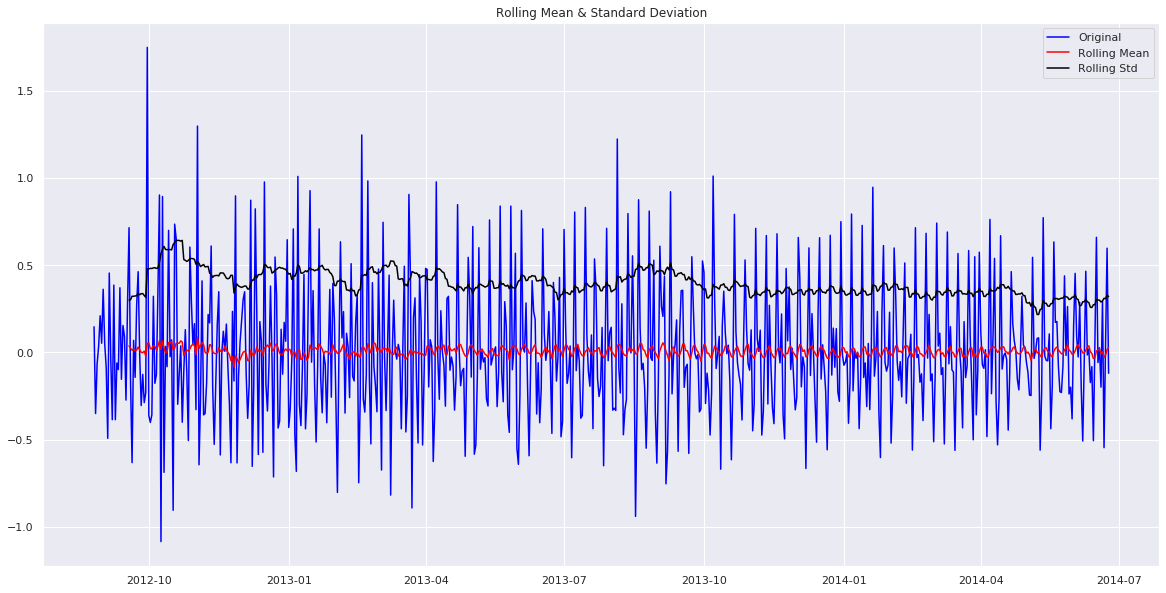

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
dtype: float64
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
dtype: float64
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [48]:
train_log_diff = Train_log - Train_log.shift(1)

test_stationarity(train_log_diff.dropna())